In [1]:
# import pylsl
%matplotlib qt5
%config Completer.use_jedi = False

import mne
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from scipy.signal import find_peaks

In [2]:
SAMPLING_FREQUENCY = 5000 #Hz
CHANNEL_NUMBER = 12
BANDPASS_LIMITS = (200, 1000)

In [3]:
#Функция чтения для данных, в нее нужно передавать хедер файл записанных данных (.vhdr) Event_id раньше были стандартные 10001 и 10002,
#теперь в данных будет 8 меток, те которые посыдадись на NVX, нужно руками будет каждую вторую или треть метка в массиве events переименовать,
#чтобы шла классификация обратного движения
def read_data(filename, show=True, event_id=[1, 2]):
    raw=mne.io.read_raw_brainvision(filename, preload=True)
    raw_hil = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)
    events=mne.events_from_annotations(raw_hil)[0]
    epochs = mne.Epochs(raw_hil, 
                        events=events,
                        event_id=[10001, 10002],
                        tmin=0, tmax=3, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)
    if show:
        raw_hil.plot()
    return epochs

In [84]:
#Read all fingers
Elbow_flexion = read_data('Data/Elbow_flexion_extension.vhdr', show=False)
Pointing_grip = read_data('Data/Pointing_grip.vhdr', show=False)
Precise_grip = read_data('Data/Precise_grip.vhdr', show=False)
Power_grip = read_data('Data/Power_grip.vhdr', show=False)
Supination_pronation = read_data('Data/Supination_pronation.vhdr', show=False)
Thumb_grip = read_data('Data/Thumb_grip.vhdr', show=False)
Wrist_flexion_extension = read_data('Data/Wrist_flexion_extension.vhdr', show=False)

Extracting parameters from Data/Elbow_flexion_extension.vhdr...
Setting channel info structure...
Reading 0 ... 771568  =      0.000 ...   154.314 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

In [15]:
# Функция которая выделяля разлиные фичи на данных, здесь можно ссылаться на статью http://ieeexplore.ieee.org/document/7752831/
# там перечислена куча фич которые можно использовать, но нужно не переусердствавоть, некоторые признаки тяжело считать и в режими реального времени
# классификацию будет невозможно осуществлять
def get_features_labels(epochs):
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, SAMPLING_FREQUENCY, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]
        # # Mean absolute value
        # for channel in raw.get_data():
        #     x__.append(channel.mean())
        # # Matematical expactation
        # for channel in raw.get_data():
        #     x__.append(channel.std())
        # # Variance
        # for channel in raw.get_data():
        #     x__.append(channel.var())
        # # Waveform length
        # for channel in raw.get_data():
        #     x__.append(np.sum(np.diff(channel, n=1)))
        # # Number pf peaks
        # for channel in raw.get_data():
        #     x__.append(len(find_peaks(channel)))
        
        # Append PCA of epoch data
        pca = PCA(6) # Пока в качестве очень быстро вариант использует PCA компоненты в качестве фич
        pv = pca.fit_transform(epochs._data[i])
        x__ = [*x__, *pv.flatten()]
        # Отрисовать метрики
        X.append(x__)
    X = np.array(X).squeeze()
    y = epochs.events[:,-1].flatten()
    return X, y

In [86]:
accuracies=[]
movements=[Elbow_flexion, Pointing_grip, Precise_grip, Power_grip, Supination_pronation, Thumb_grip, Wrist_flexion_extension]
for movement in movements:
    X, y = get_features_labels(movement)
    classifier = SVC(C=0.8, kernel='rbf', probability=True) # Здесь можно попробовать различные классификаторы, но у меня получилось на stacking неплохые результаты
    # cross_val_score(classifier, X, y, cv=3)
    classifier.fit(X, y)
    accuracies.append(classifier.score(X, y))
display(accuracies)

[0.8620689655172413,
 0.9285714285714286,
 0.9032258064516129,
 1.0,
 0.76,
 0.7195121951219512,
 0.9772727272727273]

In [87]:
plt.bar(['Elbow_flexion', 'Pointing_grip', 'Precise_grip', 'Power_grip', 'Supination_pronation', 'Thumb_grip', 'Wrist_flexion_extension'], accuracies)
plt.show()

In [88]:
mne.epochs.equalize_epoch_counts(movements) # уравниваем количество эпох

Dropped 14 epochs: 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Dropped 12 epochs: 11, 15, 19, 23, 27, 31, 34, 37, 40, 43, 46, 49
Dropped 18 epochs: 4, 8, 11, 14, 18, 22, 26, 29, 33, 36, 39, 43, 46, 48, 51, 55, 57, 59
Dropped 14 epochs: 21, 30, 35, 41, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57
Dropped 6 epochs: 44, 45, 46, 47, 48, 49
Dropped 38 epochs: 0, 8, 13, 18, 22, 28, 31, 38, 40, 43, 46, 49, 52, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81
Dropped 0 epochs: 


In [89]:
# Как раньше я записал все в одной записи отдельная для каждого пальца было две метки прямое движение и обратное, в этом блоке переименовываются события для дальнейшего объединения в одну запись
def rename_events(epochs_obj, event_name='', event_ids=[1, 2]):
    epochs_obj.events = np.where(epochs_obj.events == 10001, event_ids[0], epochs_obj.events)
    epochs_obj.events = np.where(epochs_obj.events == 10002, event_ids[1], epochs_obj.events)
    epochs_obj.event_id = {f'{event_name} forward': event_ids[0], f'{event_name} backward': event_ids[1]} 
                           # 'Start of the record': 99999}
    
movements=[Elbow_flexion, Pointing_grip, Precise_grip, 
           Power_grip, Supination_pronation, Thumb_grip, Wrist_flexion_extension]
grips=['Elbow_flexion', 'Pointing_grip', 'Precise_grip', 
        'Power_grip', 'Supination_pronation', 'Thumb_grip', 'Wrist_flexion_extension']
for i in range(len(grips)):
    rename_events(movements[i], event_name=grips[i], event_ids=[i, i+1])

#     Pointing_grip.event_id = {'Pointing_grip forward': 3, 'Pointing_grip backward': 4}
# Pointing_grip.events = np.where(Pointing_grip.events == 10001, 3, Pointing_grip.events)
# Pointing_grip.events = np.where(Pointing_grip.events == 10002, 4, Pointing_grip.events)
# Precise_grip.event_id = {'Precise_grip forward': 1, 'Precise_grip backward': 2}
# Precise_grip.events = np.where(Precise_grip.events == 10001, 1, Precise_grip.events)
# Precise_grip.events = np.where(Precise_grip.events == 10002, 2, Precise_grip.events)
# Power_grip.event_id = {'Precise_grip forward': 1, 'Precise_grip backward': 2}
# Power_grip.events = np.where(Power_grip.events == 10001, 1, Power_grip.events)
# Power_grip.events = np.where(Power_grip.events == 10002, 2, Power_grip.events)
# # Power_grip.event_id = {'Ring forward': 5, 'Ring backward': 6}
# # thumb_epochs.events = np.where(thumb_epochs.events == 1, 7, thumb_epochs.events)
# # thumb_epochs.events = np.where(thumb_epochs.events == 2, 8, thumb_epochs.events)
# thumb_epochs.event_id = {'Thumb forward': 7, 'Thumb backward': 8}

In [90]:
for movement in movements:
    display(movement)

Number of events,44
Events,Elbow_flexion backward: 22Elbow_flexion forward: 22
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Pointing_grip backward: 19Pointing_grip forward: 25
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Precise_grip backward: 22Precise_grip forward: 22
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Power_grip backward: 21Power_grip forward: 23
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Supination_pronation backward: 22Supination_pronation forward: 22
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Thumb_grip backward: 22Thumb_grip forward: 22
Time range,0.000 – 3.000 sec
Baseline,off


Number of events,44
Events,Wrist_flexion_extension backward: 22Wrist_flexion_extension forward: 22
Time range,0.000 – 3.000 sec
Baseline,off


In [107]:
# Объединяем эпохи в одну
all_epochs = mne.concatenate_epochs([Elbow_flexion, Power_grip, Supination_pronation], add_offset=True, verbose=True)
           # Power_grip, Supination_pronation, Thumb_grip])

Not setting metadata
Not setting metadata
132 matching events found
No baseline correction applied
0 bad epochs dropped


In [109]:
# Обучаем классификатор уже на 15 классах движений и проверяем точность
X, y = get_features_labels(all_epochs)
svc = SVC(C=0.9, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=100, n_jobs=4)
classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])
# cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
display(classifier.score(X, y))

0.8484848484848485

## Features extraction code
1. Time domain
    1. Mean absolute value
    1. STD
    1. Variance
    1. Waveform length!
    1. Number of peaks
2. Frequency domain
    2. Waveform length
    2. Mean frequecy
    2. Standard deviation of peaks
    2. Freqpvuency ratio
    2. Frequency energy


In [194]:
raw=mne.io.read_raw_brainvision('Data/Pointing_grip.vhdr', preload=True).filter(200, 1000)
raw = raw.copy().filter(200, 1000).apply_hilbert(envelope=True).filter(0, 20)
events=mne.events_from_annotations(raw)[0]
epochs = mne.Epochs(raw, 
                    events=events, 
                    tmin=0, tmax=1.5, 
                    preload=True, 
                    baseline=None)

Extracting parameters from Data/Pointing_grip.vhdr...
Setting channel info structure...
Reading 0 ... 524644  =      0.000 ...   104.929 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 

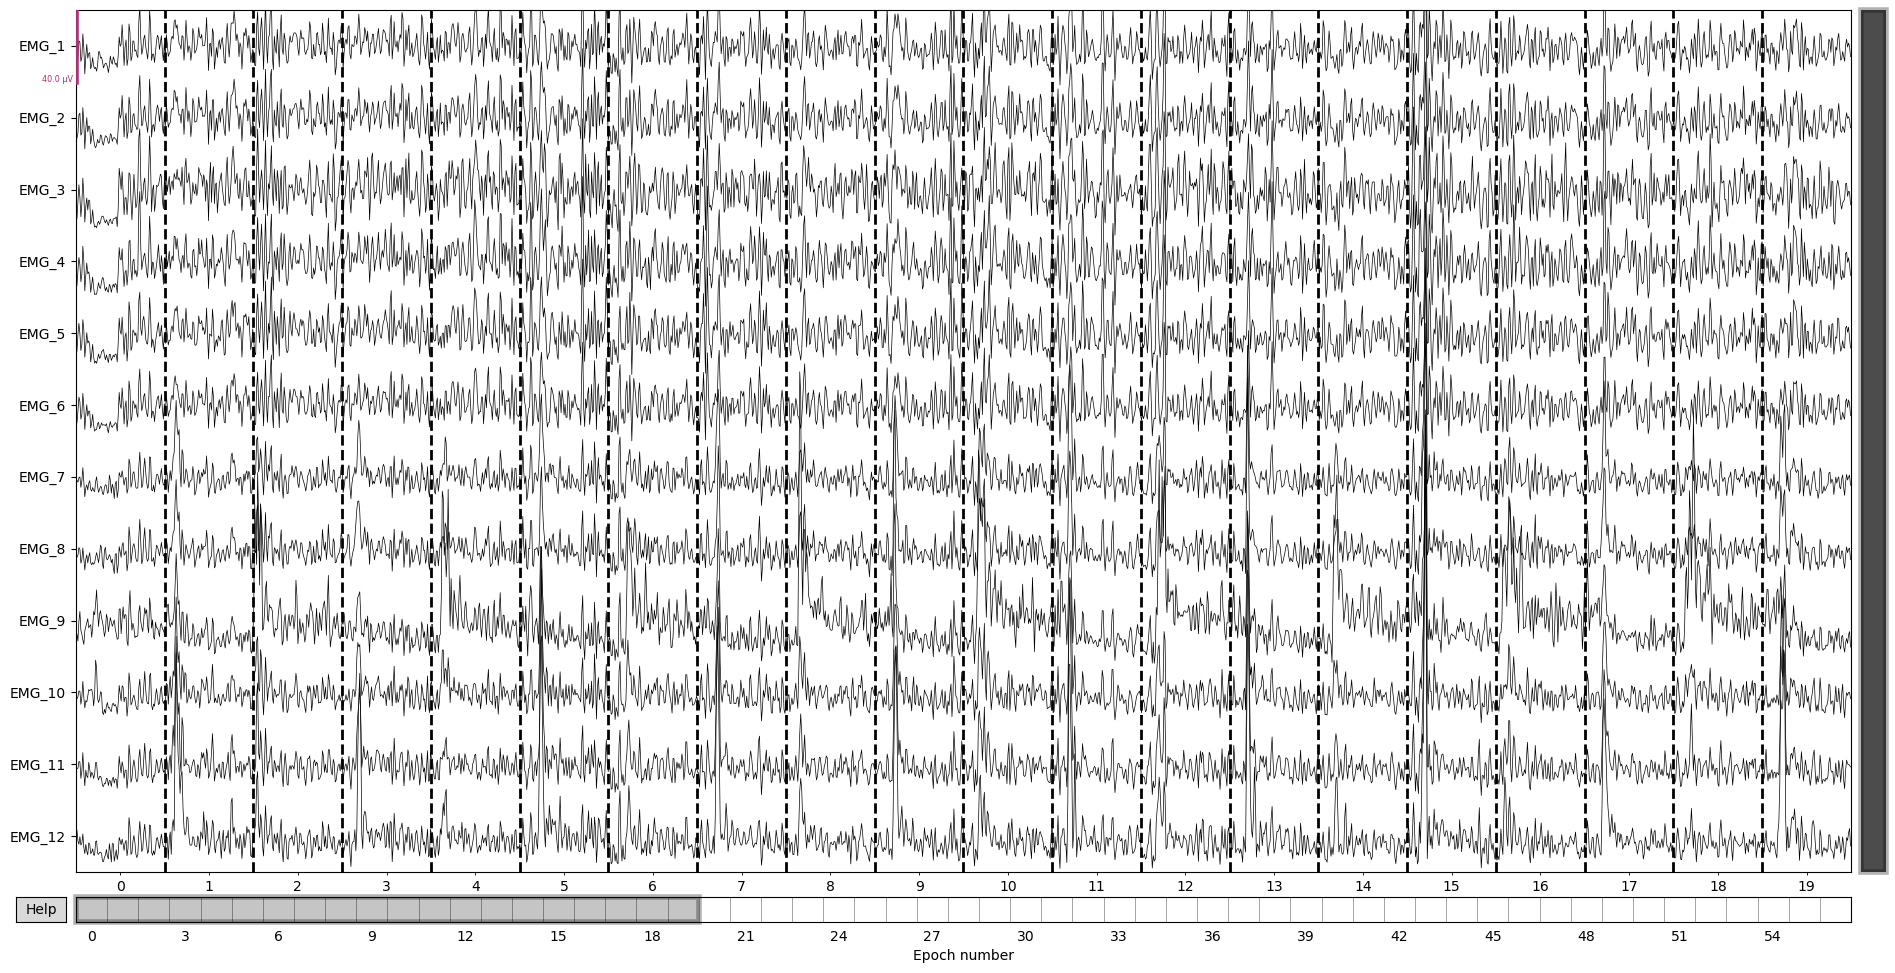

Dropped 0 epochs: 
Channels marked as bad: none


In [195]:
epochs.plot()

In [196]:
epochs=epochs
X=[]
FS=5000
Time=2
Wind=1
ch_num=12

for i in range(epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['emg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000, picks=['emg'])
    x__ = []
    for channel in raw.get_data():
        x__.append(channel.mean())
    for channel in raw.get_data():
        x__.append(channel.std())
    for channel in raw.get_data():
        x__.append(channel.var())
    pca = PCA(6)
    pv = pca.fit_transform(epochs._data[i])
    x__ = [*x__, *pv.flatten().tolist()]
    # x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    # x_=np.array(x__).flatten().reshape(1,-1)
    X.append(x__) 

In [197]:
X=np.array(X).squeeze()

In [198]:
X.shape

(57, 108)

In [199]:
y = epochs.events[:,-1].flatten()

In [216]:
svc = SVC(C=0.8, kernel='rbf', probability=True)
# classifier = RandomForestClassifier(bootstrap=True, max_depth=14, n_estimators=5, n_jobs=4)
dt = DecisionTreeClassifier(max_depth=10)
stacking_classifier = StackingClassifier([('svc', svc), ('dt', dt)])

stacking_classifier.fit(X, y)

c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validat

StackingClassifier(estimators=[('svc', SVC(C=0.8, probability=True)),
                               ('dt', DecisionTreeClassifier(max_depth=10))])

In [217]:
stacking_classifier.score(X, y)

0.7719298245614035

In [204]:
epochs=epochs
X=[]
FS=5000
Time=2
Wind=1
ch_num=12

for i in range(epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['eeg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000)
    x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    x_=x__.flatten().reshape(1,-1)
    X.append(x_) 
X=np.array(X).squeeze()

In [219]:
cross_val_score(stacking_classifier, X, y, cv=3)

c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_valida

array([0.57894737, 0.42105263, 0.42105263])

In [4]:
raw_elbow=mne.io.read_raw_brainvision('Data/Elbow_flexion_extension.vhdr', preload=True).filter(200, 1000)
raw_power=mne.io.read_raw_brainvision('Data/Power_grip.vhdr', preload=True).filter(200, 1000)
raw_precise=mne.io.read_raw_brainvision('Data/Precise_grip.vhdr', preload=True).filter(200, 1000)
raw_thumb=mne.io.read_raw_brainvision('Data/Thumb_grip.vhdr', preload=True).filter(200, 1000)
raw_pointing=mne.io.read_raw_brainvision('Data/Pointing_grip.vhdr', preload=True).filter(200, 1000)
raw_wrist=mne.io.read_raw_brainvision('Data/Wrist_flexion_extension.vhdr', preload=True).filter(200, 1000)
raw_supination=mne.io.read_raw_brainvision('Data/Supination_pronation.vhdr', preload=True).filter(200, 1000)

Extracting parameters from Data/Elbow_flexion_extension.vhdr...
Setting channel info structure...
Reading 0 ... 771568  =      0.000 ...   154.314 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Extracting parameters from Data/Power_grip.vhdr...
Setting channel info structure...
Reading 0 ... 631059  =      0.000 ...   126.212 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
-------

In [5]:
raw = mne.concatenate_raws([raw_pointing, raw_power, raw_elbow, raw_precise, raw_supination, raw_thumb, raw_wrist])

In [9]:
events = mne.events_from_annotations(raw)[0]
events

Used Annotations descriptions: ['1/Forward_1', '1/Forward_2', '1/Forward_3', '1/Forward_4', '1/Forward_5', '1/Forward_6', '1/Forward_7', '2/Backward_1', '2/Backward_2', '2/Backward_3', '2/Backward_4', '2/Backward_5', '2/Backward_6', '2/Backward_7', 'New Segment/']


array([[      0,       0,   99999],
       [  33779,       0,   10002],
       [  43351,       0,   10009],
       ...,
       [4331795,       0,   10014],
       [4346055,       0,   10007],
       [4359495,       0,   10014]])

In [10]:
epochs_all=mne.Epochs(raw, 
                    events=events,
                    event_id=[10000 + i for i in range(1, 15)],
                    tmin=0, tmax=3, 
                    preload=True, 
                    baseline=None)

Not setting metadata
Not setting metadata
410 matching events found
No baseline correction applied
0 projection items activated
Loading data for 410 events and 15001 original time points ...
0 bad epochs dropped


In [11]:
epochs_all

Number of events,410
Events,10001: 2910002: 2810003: 2910004: 3110005: 2510006: 4210007: 2210008: 2910009: 2810010: 2910011: 3110012: 2510013: 4010014: 22
Time range,0.000 – 3.000 sec
Baseline,off


In [12]:
epochs_all.equalize_event_counts()

Dropped 102 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 234, 235, 236, 237, 238, 239, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 321, 323


(<Epochs |  308 events (all good), 0 - 3 sec, baseline off, ~423.0 MB, data loaded,
  '10001': 22
  '10002': 22
  '10003': 22
  '10004': 22
  '10005': 22
  '10006': 22
  '10007': 22
  '10008': 22
  '10009': 22
  '10010': 22
  '10011': 22
  '10012': 22
  '10013': 22
  '10014': 22>,
 array([114, 116, 118, 120, 122, 124, 126,   0,   2,   4,   6,   8,  10,
         56,  58,  60,  62,  64,  66,  68, 172, 174, 176, 178, 180, 182,
        184, 186, 188, 234, 236, 238, 284, 286, 288, 290, 292, 294, 296,
        298, 300, 302, 304, 308, 309, 311, 313, 315, 317, 319, 321, 323,
        115, 117, 119, 121, 123, 125, 127,   1,   3,   5,   7,   9,  11,
         57,  59,  61,  63,  65,  67,  69, 173, 175, 177, 179, 181, 183,
        185, 187, 189, 235, 237, 239, 285, 287, 289, 291, 293, 295, 297,
        299, 301, 303, 305, 306, 307, 310, 312, 314, 316, 318], dtype=int64))

In [13]:
epochs_all

Number of events,308
Events,10001: 2210002: 2210003: 2210004: 2210005: 2210006: 2210007: 2210008: 2210009: 2210010: 2210011: 2210012: 2210013: 2210014: 22
Time range,0.000 – 3.000 sec
Baseline,off


In [16]:
X, y = get_features_labels(epochs_all)
svc = SVC(C=0.9, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=1000, n_jobs=4)
classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])
# cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
display(classifier.score(X, y))

0.7077922077922078

In [17]:
plot_confusion_matrix(classifier, X, y)

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
